# How to Implement a First-Order Low-Pass Filter in Discrete Time

Copyright &copy; 2021 [Joshua Marshall](https://www.ece.queensu.ca/people/j-marshall/)

We often teach or learn about filters in continuous time, but then need to implement them in discrete time (e.g., in code) on data acquired at discrete sample times.  This notebook shows one way to design and implement a simple first-order low-pass filter in discrete time.

## Filter Model Derivation

Let's start with an integrator, which can be approximated in discrete time by any number of methods.  For this example, we use a [trapezoidal approximation](https://en.wikipedia.org/wiki/Trapezoidal_rule)
$$\int_{(k-1)T}^{kT}f(\tau)d\tau \approx \frac{T}{2}\left(f[k]+f[k-1]\right),$$
where $T>0$ be the step tiem (i.e., sample period), $k=1,2,\ldots$ is the time index, and $f[k]:=f(kT)$.  Thus, the integral from $t=0$ to the current time $kT$ is 
$$i[k]=\int_{0}^{kT}f(\tau)d\tau \approx i[k-1] + \frac{T}{2}\left(f[k]+f[k-1]\right).$$
Now, let the [$z$-transform](https://en.wikipedia.org/wiki/Z-transform) of $i(t)$ and $f(t)$ be $I(z)$ and $F(z)$, respectively, where $z^{-1}$ denotes a unit time delay of period $T$.  Therefore, taking the $z$-transform of the integral approximation above yields
$$G_I(z) = \frac{T}{2}\left(\frac{1+z^{-1}}{1-z^{-1}}\right) =\frac{I(z)}{F(z)}.$$
This formula is often called [Tustin's method](https://en.wikipedia.org/wiki/Bilinear_transform).  For those more familar with the Laplace domain, Tustin's method uses a first-order approximation for the integral $1/s$ such that
$$s\approx \frac{2}{T}\left(\frac{1-z^{-1}}{1+z^{-1}}\right).$$

We now have the machinery to build a first-order low-pass filter.  For simplicity, let $Y(z)$ be the out put of our filter with input $X(z)$.  In continuious time, the [frequency response of a low-pass filter](https://en.wikipedia.org/wiki/Low-pass_filter#Frequency_response) is given by 
$$G_{\rm LPF}(s) = \frac{\omega_c}{s+\omega_c},$$
where $\omega_c$ \[rad/s\] is the filter's [cut-off frequency](https://en.wikipedia.org/wiki/Cutoff_frequency).  Substituting our above approximtion for $s$ into $G_{\rm LPF}(s)$ we obtain
$$G_{\rm LPF}(z) = \frac{T\omega_c(1+z^{-1})}{(T\omega_c+2)+(T\omega_c-2)z^{-1}} = \frac{Y(z)}{X(z)},$$
where $Y(z)$ is the filtered version of $X(z)$.

Therefore, using our expression for the filter transfer function $G_{\rm LPF}(z)$ we can write
$$ Y(z)\left(T\omega_c+2 + (T\omega_c-2)z^{-1}\right) = T\omega_c(1+z^{-1})X(z).$$ 
Thus, in the time domain, we obtain
$$(T\omega_c + 2)y[k] + (T\omega_c-2)y[k-1] = T\omega_c\left(x[k]+x[k-1]\right),$$
which can be rearranged to obtain
$$y[k] = \left(\frac{2-T\omega_c}{2+T\omega_c}\right)y[k-1] + \left(\frac{T\omega_c}{2+T\omega_c}\right)\left(x[k]+x[k-1]\right),$$ 
where $x[k]$ is the input at time $t=kT$ and $y[k]$ is the filtered output at time $t=kT$.

## Example Implementation

Let's try out our design on some contrived data.

### Create Test Input Data

Let's create some input data with two frequencies that are sufficiently far apart.

In [41]:
import numpy as np

Set the simulation time as `SIM_TIME` \[s\] and the sample period $T$ as `T` \[s\].

In [42]:
SIM_TIME = 15
T = 0.01

In [43]:
t = np.arange(0.0, SIM_TIME, T)
N = np.size(t)

Create two contrived periodic signals $x_1$ and $x_2$ with frequencies $f_1$ and $f_2$ \[Hz\], respectively.

In [44]:
f_1 = 0.25
f_2 = 5.0
x_1 = np.sin(2.0*np.pi*f_1*t)
x_2 = np.sin(2.0*np.pi*f_2*t)

### Plot the Input Signal

Now plow the signals.

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

In [46]:
%config InlineBackend.figure_format = 'svg'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright,amsmath}')

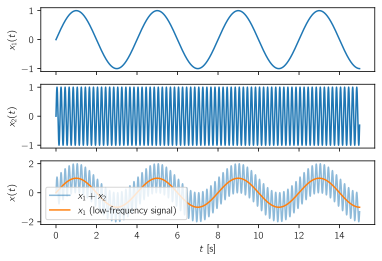

In [47]:
plt.subplot(311)
plt.plot(t, x_1)
plt.ylabel('$x_1(t)$')
plt.setp(plt.gca(),xticklabels=[])
plt.subplot(312)
plt.plot(t, x_2)
plt.ylabel('$x_2(t)$')
plt.setp(plt.gca(),xticklabels=[])
plt.subplot(313)
plt.plot(t, x_1+x_2, alpha=0.5, label='$x_1+x_2$')
plt.plot(t, x_1, label='$x_1$ (low-frequency signal)')
plt.xlabel('$t$ [s]')
plt.ylabel('$x(t)$')
plt.legend()
plt.show()

### Filter Implementation

In [48]:
def lpf(x, omega_c, T):
    """Implement a first-order low-pass filter.
    
    The input data is x, the filter's cutoff frequency is omega_c 
    [rad/s] and the sample time is T [s].  The output is y.
    """
    y = x
    alpha = (2-T*omega_c)/(2+T*omega_c)
    beta = T*omega_c/(2+T*omega_c)
    for k in range(1, N):
        y[k] = alpha*y[k-1] + beta*(x[k]+x[k-1])
    return y

Pick a cutoff frequency $\omega_c$ somewhere between the low and high frequency components in the signal, and then run the filter.

In [49]:
omega_c = 2.0*np.pi*(f_1+f_2)/2.0
y = lpf(x_1+x_2, omega_c, T)

### Plot the Output Signal

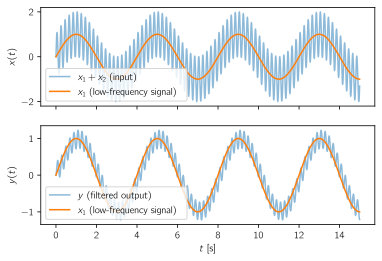

In [50]:
plt.subplot(211)
plt.plot(t, x_1+x_2, alpha=0.5, label='$x_1+x_2$ (input)')
plt.plot(t, x_1, label='$x_1$ (low-frequency signal)')
plt.ylabel('$x(t)$')
plt.setp(plt.gca(),xticklabels=[])
plt.legend()
plt.subplot(212)
plt.plot(t, y, alpha=0.5, label='$y$ (filtered output)')
plt.plot(t, x_1, label='$x_1$ (low-frequency signal)')
plt.xlabel('$t$ [s]')
plt.ylabel('$y(t)$')
plt.legend()
plt.show()

Notice how the filtered signal $y[k]$ does not perfectly match $x_1[k]$ but that the higher-frequency component $x_2[k]$ is significantly attenuated.  Play around with the filter cut-off frequency $\omega_c$ to get a feeling for how the filter behaves and what to expect should you use this for your given application.